In [ ]:
#pip install qiskit

In [ ]:
#pip install qiskit_ibm_runtime

In [ ]:
#pip install qiskit_optimization

In [ ]:
#pip install qiskit-ibmq-provider

In [1]:
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
import qiskit.tools.jupyter

%qiskit_version_table

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

from itertools import permutations #per brutal approches TSP

In [4]:
#draw a graph coloring the nodes

#funzione per disegnare un grafo con nodi colorati
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

#funzione per disegnare un cammino su un grafo
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

### TSP

distance
 [[ 0.  7. 28. 41.]
 [ 7.  0. 34. 35.]
 [28. 34.  0. 69.]
 [41. 35. 69.  0.]]


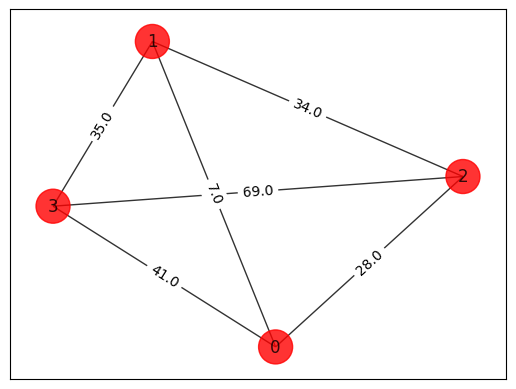

In [5]:
# Generating a random graph
n = 4 # num
num_qubits = n**2
tsp = Tsp.create_random_instance(n)
G=tsp.graph


# Creating a specific graph

#n=3 #numero di nodi
#G= nx.Graph() # definizione del grafo
#G.add_nodes_from(np.arange(0, n, 1)) # aggiungo i vertici
#elist = [(0, 1, 1), (0, 2, 1), (1, 2, 3)] # definisco la lista degli archi [(i,j,peso)]
### tuple is (i,j,weight) where (i,j) is the edge
#G.add_weighted_edges_from(elist)# aggiungo gli archi al grafo

#tsp=Tsp(G)

# grafico
adj_matrix = nx.to_numpy_array(G)
print("distance\n", adj_matrix)
colors = ["r" for node in G.nodes]
pos = nx.spring_layout(G)
draw_graph(tsp.graph, colors, pos)


In [6]:
## define the ising model

qp = tsp.to_quadratic_program()
qp2qubo= QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [7]:
###EXACT SOLUTION
###Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z= tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))

energy: -27698.0
tsp objective: 138.0
feasible: True
solution: [3, 0, 2, 1]
solution objective: 138.0


In [9]:
# create the ANSATZ

###standard ansatz
#ansatz= TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=2, entanglement="linear")

###specific ansatz no constrain
#theta = ParameterVector('theta', qubitOp.num_qubits)
#ansatz = QuantumCircuit(qubitOp.num_qubits)
#for i in range (0,qubitOp.num_qubits, tsp.graph.number_of_nodes()):
#    ansatz.x(i)
#    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
#        ansatz.ry(theta[j-1], j)
#        ansatz.cz(j-1,j)
#        ansatz.ry(-theta[j-1], j)
#    for j in range(i+1,i+tsp.graph.number_of_nodes(),1):
#        ansatz.cx(j,j-1)

In [10]:
# create the Ansatz
def W_circuit(QC, n, q1n, theta):
    QC.x(q1n)
    #QC.barrier(range(q1n,q1n+n))
    for j in range(q1n+1,q1n+n,1):
        QC.ry(theta[j-1], j)
        QC.cz(j-1,j)
        QC.ry(-theta[j-1], j)
        #QC.barrier(range(q1n,q1n+n))
    for j in range(q1n+1,q1n+n,1):
        QC.cx(j,j-1)

def base_circuit(QC, n, theta):
    #theta1 = ParameterVector('theta2', 1)
    QC.x(0)
    #QC.barrier(range(0,n-1))
    QC.ry(theta[1], 1)
    QC.cz(0,1)
    QC.ry(-theta[1], 1)
    QC.cx(1,0)
    QC.cx(1,n)
    QC.cx(0,n+1)


In [11]:
qc = QuantumCircuit(n**2)
phi=ParameterVector('phi', n**2)
base_circuit(qc,n, phi)
for i in range(3,n+1,1):
    W_circuit(qc, i, n*(i-1), phi)
    #qc.barrier()
for v in range(1,n,1):
    for p in range(1,n,1):
        qc.cswap(n*(n-1)+v-1,n*(p-1)+n-1,n*(p-1)+v-1)
ansatz=qc
#qc.draw('mpl',plot_barriers=False)

In [12]:
from qiskit.primitives import Sampler # per esecuzione in locale

In [16]:
# in locale
optimizer = COBYLA(maxiter=40) #define the optimizer
vqe= SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
# run SamplingVQE
result=vqe.compute_minimum_eigenvalue(qubitOp)



energy: -27697.84558341868
time: 5.4725141525268555
feasible: True
solution: [3, 1, 2, 0]
solution objective: 138.0


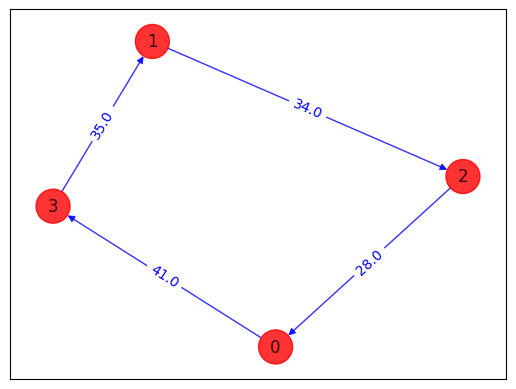

In [17]:
#result

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp.is_feasible(x))
z = tsp.interpret(x) #cammino
print("solution:", z)
p=tsp.tsp_value(z, adj_matrix) # peso totale del cammino
print("solution objective:", p)
draw_tsp_solution(tsp.graph, z, colors, pos) #plot della soluzioe

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler #solo per eseguire il cicuito in runtime

In [19]:
my_api_token = 'ec2b0d00148c8c9170e3bfdd1d64a8088e38de7b2fb87141de693f458b4f30b9ba7831a9215f7b2db8fb8a0fdf2e7d6076013d1fcbbd2f571dfd7c1ebb621402' #inserire Api token

In [20]:
service = QiskitRuntimeService(channel="ibm_quantum", token= my_api_token)

qiskit_runtime_service.__init__:INFO:2024-01-01 21:16:42,710: Default instance: ibm-q/open/main


In [21]:
optimizer = COBYLA(maxiter=35) #define the optimizer
backend=service.backend("ibmq_qasm_simulator") #scegli backend
with Session (backend=backend) as s:
    vqe_mes= SamplingVQE(sampler=Sampler(backend=backend, session=s), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
    # run SamplingVQE
    vqe = MinimumEigenOptimizer ( vqe_mes )
    result = vqe . solve (qp)
s.close()

base_primitive._run_primitive:INFO:2024-01-01 21:16:44,225: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
/opt/conda/lib/python3.10/site-packages/qiskit/qpy/binary_io/circuits.py:1191: UserWarning: The ParameterVector: 'phi' is not fully identical to its pre-serialization state. Elements 0, 2, 3, 4, 5, 6, 7, 10, 11, 15 in the ParameterVector will be not equal to the pre-serialized ParameterVector as they weren't used in the circuit: circuit-152
  warnings.warn(
base_primitive._run_primitive:INFO:2024-01-01 21:16:48,276: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilatio

fval=138.0, x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0, status=SUCCESS
objective function value: 138.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS
solution: [3, 0, 2, 1]
solution objective: 138.0


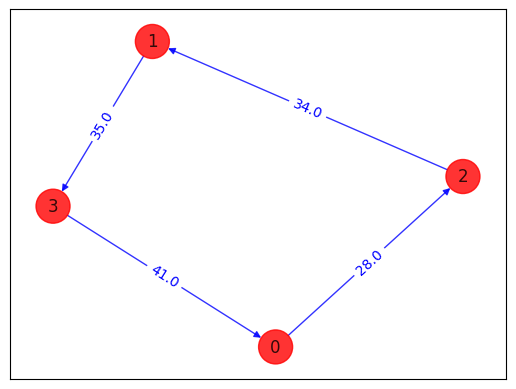

In [23]:
print(result)
print(result.prettyprint())
z=tsp.interpret(result)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [24]:
optimizer = COBYLA(maxiter=35) #define the optimizer
backend=service.backend("ibmq_qasm_simulator") #scegli backend
with Session (backend=backend) as s:
    vqe= SamplingVQE(sampler=Sampler(backend=backend, session=s), ansatz=ansatz, optimizer=optimizer) #define the SamplingVqe
    # run SamplingVQE
    result = vqe.compute_minimum_eigenvalue(qubitOp)
s.close()

base_primitive._run_primitive:INFO:2024-01-01 21:18:37,518: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
base_primitive._run_primitive:INFO:2024-01-01 21:18:40,088: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
base_primitive._run_primitive:INFO:2024-01-01 21:18:43,356: Submitti

energy: -27697.12525
time: 108.5899486541748
feasible: True
solution: [3, 1, 2, 0]
solution objective: 138.0


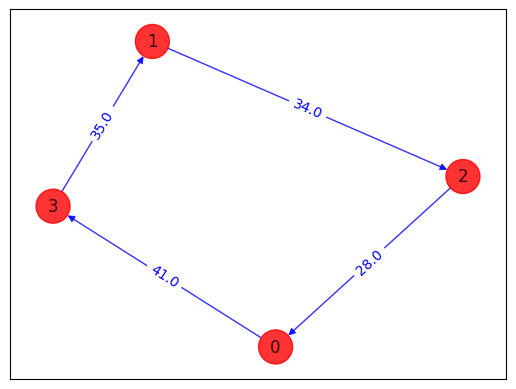

In [25]:
#result

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x= tsp.sample_most_likely(result.eigenstate)
print("feasible:", qp.is_feasible(x))
z = tsp.interpret(x) #cammino
print("solution:", z)
p=tsp.tsp_value(z, adj_matrix) # peso totale del cammino
print("solution objective:", p)
draw_tsp_solution(tsp.graph, z, colors, pos) #plot della soluzioe